### The idea being researched in this notebook is to have equal factor exposure (PCA factors) for maximum diversification. Optimisation is done with KL divergence as the loss and gradient descent as an optimization strategy. 

In [7]:
import numpy as np
from scipy.misc import derivative
from scipy.optimize import approx_fprime
from pandas_datareader import data
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [8]:
stocks = ["UN", "AAPL","IBM","MSFT","FB","AAPL","MMM","ABT","ALLE","AAP"]

In [9]:
prices = data.DataReader(stocks, 
                       start='2015-1-1', 
                       end='2015-12-31', 
                       data_source='yahoo')['Adj Close']
returns = prices.pct_change().dropna()

In [31]:
prices_oos = data.DataReader(stocks, 
                       start='2016-1-1', 
                       end='2016-7-1', 
                       data_source='yahoo')['Adj Close']

returns_oos = prices_oos.pct_change().dropna()

In [11]:
returns.head()

Symbols,UN,AAPL,IBM,MSFT,FB,MMM,ABT,ALLE,AAP
Date,,,,,,,,,
2015-01-05,-0.025310,-0.028172,-0.015735,-0.009196,-0.016061,-0.022553,0.000223,-0.001998,-0.013181
2015-01-06,-0.002650,0.000094,-0.021566,-0.014677,-0.013473,-0.010663,-0.011356,-0.001638,-0.000703
2015-01-07,0.013550,0.014022,-0.006535,0.012705,0.000000,0.007249,0.008108,0.013674,0.021489
2015-01-08,0.021232,0.038422,0.021735,0.029418,0.026658,0.023967,0.020554,0.013489,0.008765
2015-01-09,-0.010010,0.001072,0.004355,-0.008405,-0.005628,-0.012283,-0.010508,-0.008341,-0.005089


In [12]:
def factor_exposure(returns, weights):

    correct_weights = abs(weights)/np.sum(abs(weights))
        
    weighted_port = [w*returns.iloc[:,i].values 
                     for i, w in enumerate(correct_weights)]

    pca = PCA()
    factors = pca.fit_transform(weighted_port)
    
    return pca.explained_variance_ratio_

In [13]:
def training_loss(weights):
    
    exposure = factor_exposure(returns, weights)
    
    uniform = 1/len(exposure)
    target = np.ones(len(exposure)) * uniform
    
    probs = exposure * target + (1 - exposure) * (1 - target)
    
    return -np.sum(np.log(probs))    

In [14]:
def optimize_weights(returns, iterations=100):
    
    weights = np.ones(returns.shape[1])/returns.shape[1]
    epsilon = np.ones(len(weights))*1e-6

    losses = [training_loss(weights)]

    for i in range(iterations):
        gradients = approx_fprime(weights, training_loss, epsilon=epsilon)
        weights -= gradients

        losses.append(training_loss(weights))

    correct_weights = abs(weights)/np.sum(abs(weights))
    
    return correct_weights

In [19]:
correct_weights = optimize_weights(returns)

Text(0.5, 1.0, 'Optimized weighting')

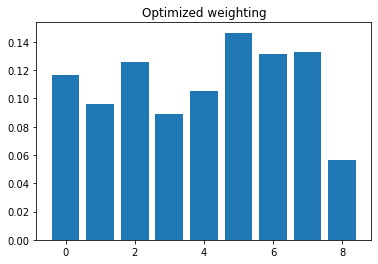

In [26]:
plt.bar(x=np.arange(len(correct_weights)), height=correct_weights)
plt.title("Optimized weighting")

Text(0.5, 1.0, 'Equal weight exposure')

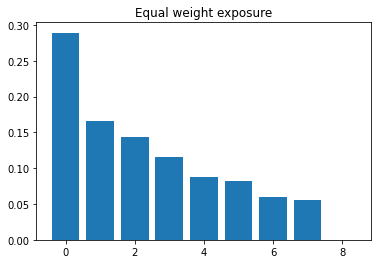

In [24]:
equal_weight_exposure = factor_exposure(returns, np.ones(returns.shape[1])/returns.shape[1])
plt.bar(x=np.arange(len(equal_weight_exposure)), height=equal_weight_exposure)
plt.title("Equal weight exposure")

Text(0.5, 1.0, 'Optimized exposure')

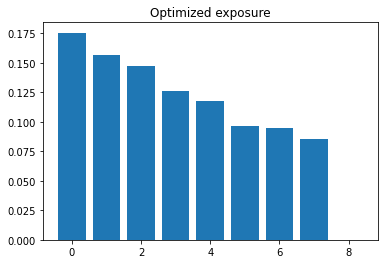

In [27]:
exposures = factor_exposure(returns, correct_weights)
plt.bar(x=np.arange(len(exposures)), height=exposures)
plt.title("Optimized exposure")

In [28]:
def allocation_over_time(returns, weights):
    
    alloc = [100 * weights]
    
    for t in range(returns.shape[0]):
        ret = returns.iloc[t,:].values
        alloc.append((1+ret)*alloc[-1])
                     
    return alloc

In [42]:
def exposures_losses_over_time(returns, returns_oos, weights):
    
    train_size = returns.shape[0]
    losses = []
    exposures = []
    
    for i in range(returns_oos.shape[0]):
        returns = returns.iloc[i:,:].append(returns_oos.iloc[:i,:])

        exposure = factor_exposure(returns, weights)
    
        uniform = 1/len(exposure)
        target = np.ones(len(exposure)) * uniform

        probs = exposure * target + (1 - exposure) * (1 - target)
        
        losses.append(-np.sum(np.log(probs)))
        exposures.append(exposure)
        
    return losses, exposures

### No rebalancing

Text(0.5, 1.0, 'No rebalancing')

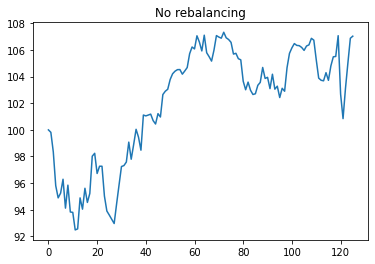

In [104]:
values = allocation_over_time(returns_oos, correct_weights)
port_values = np.array([sum(stock) for stock in values])
port_ret = (port_values[1:]-port_values[:-1])/port_values[:-1]
plt.plot(port_values)
plt.title("No rebalancing")

Text(0.5, 1.0, 'Equal weights')

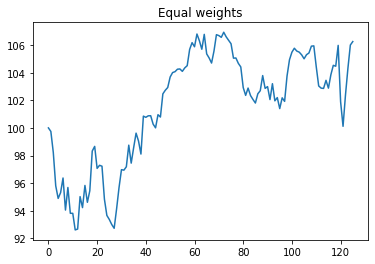

In [102]:
equal_weights = np.ones(returns_oos.shape[1])/returns_oos.shape[1]
values_eqw = allocation_over_time(returns_oos, equal_weights)
port_values_eqw = np.array([sum(stock) for stock in values_eqw])
port_ret_eqw = (port_values_eqw[1:]-port_values_eqw[:-1])/port_values_eqw[:-1]
plt.plot(port_values_eqw)
plt.title("Equal weights")

In [43]:
losses_t, exp_t = exposures_losses_over_time(returns, returns_oos, correct_weights)

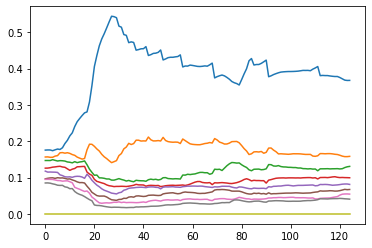

In [48]:
plt.plot(exp_t)

The optimization seems to be relevant only for about 2 or 3 weeks

### Rebalancing every 2 or 3 weeks

In [99]:
values_rebal = [100]
exposure_rebal = []

for i in range(returns_oos.shape[0]):
    returns_temp = returns.iloc[i:,:].append(returns_oos.iloc[:i,:])
    if i%10 == 0:
        weights_temp = optimize_weights(returns_temp)
    
    exposure_rebal.append(factor_exposure(returns_temp, weights_temp))
    values_rebal.append(((1+returns_oos.iloc[i,:])*values_rebal[-1]*weights_temp).sum())

Text(0.5, 1.0, 'Portfolio value with rebalancing')

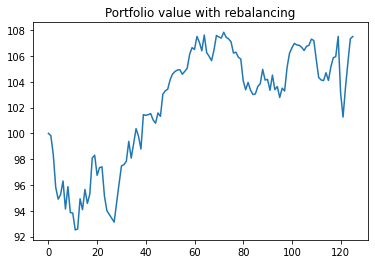

In [100]:
plt.plot(values_rebal)
plt.title("Portfolio value with rebalancing")

Text(0.5, 1.0, 'Factor exposure with rebalancing')

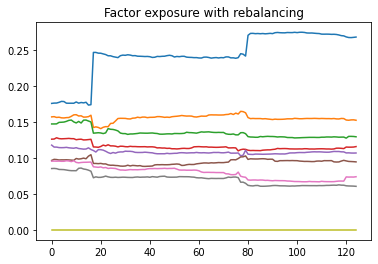

In [101]:
plt.plot(exposure_rebal)
plt.title("Factor exposure with rebalancing")

In [107]:
returns_rebal = (np.array(values_rebal[1:])-np.array(values_rebal[:1]))/np.array(values_rebal[:1])

In [112]:
returns_rebal

array([-0.00184441, -0.01655433, -0.04185837, -0.05099504, -0.04746706,
       -0.03694623, -0.05867642, -0.04133267, -0.06142325, -0.06178019,
       -0.07484922, -0.07412826, -0.05071073, -0.05921016, -0.04349562,
       -0.05431568, -0.04714368, -0.01910899, -0.01700349, -0.03250846,
       -0.02661545, -0.02598009, -0.04842671, -0.05983156, -0.06288932,
       -0.06584062, -0.06874558, -0.05391502, -0.03928193, -0.02522668,
       -0.02431478, -0.02166443, -0.00623793, -0.01920941, -0.00794135,
        0.00360639, -0.00227975, -0.01214368,  0.01444952,  0.01394665,
        0.01445121,  0.01527155,  0.01034116,  0.00783753,  0.01576268,
        0.0131548 ,  0.03031651,  0.0328995 ,  0.03422913,  0.0416366 ,
        0.04596681,  0.04789563,  0.04906857,  0.04923073,  0.04576069,
        0.04802117,  0.05041832,  0.06124727,  0.06639248,  0.06497005,
        0.07503877,  0.07058071,  0.06392772,  0.07613202,  0.06251646,
        0.05966842,  0.05631513,  0.06459595,  0.07579341,  0.07